In [ ]:
!pip install --upgrade sympy --break-system-packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 77.5 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud

## With actual images using ResNET50 TF-IDF+LR

## LR evaluation on test labels

### Load the datasets, dataset cleaning and filtering
###### Data labelling for train and val dataset,
###### Feature extraction with TF-IDF(text) and ResNET-150 (visual features)
###### Handling dimension issue
###### Fuse both text and visual features
###### text embeddings and the projected visual features are fed into a LR model
###### Evaluate the predictions for test dataset
###### Save the best models

In [ ]:
#!/usr/bin/env python3
"""
SIMPLE HATE SPEECH DETECTION
============================
TF-IDF + Logistic Regression + ResNet50
"""

import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import pickle

# Auto-install packages
def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        os.system(f"pip install {package} --break-system-packages")

install_if_missing('torch')
install_if_missing('torchvision')
install_if_missing('pillow')
install_if_missing('requests')

# Fix sympy compatibility issue
try:
    import sympy
    if not hasattr(sympy, 'printing'):
        os.system("pip install --upgrade sympy --break-system-packages")
except:
    pass

import torch
import torchvision.models as models
import torchvision.transforms as transforms

# Suppress any remaining sympy warnings
import warnings
warnings.filterwarnings('ignore', module='sympy')
warnings.filterwarnings('ignore', category=UserWarning)

def mount_drive():
    """Mount Google Drive if in Colab"""
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        return True
    except:
        return False

def load_and_process_data():
    """Load data with same preprocessing as before"""
    is_colab = mount_drive()

    if is_colab:
        train_path = "/content/drive/MyDrive/Memotion3/train.csv"
        val_path = "/content/drive/MyDrive/Memotion3/val.csv"
        test_path = "/content/drive/MyDrive/Memotion3/test_with_labels.csv"
    else:
        train_path = "train.csv"
        val_path = "val.csv"
        test_path = "test_with_labels.csv"

    def process_dataset(path, name, sample_size):
        try:
            if 'val' in name.lower():
                df = pd.read_csv(path, delimiter='\t')
            else:
                try:
                    df = pd.read_csv(path, delimiter=',')
                except:
                    df = pd.read_csv(path, delimiter='\t')

            print(f"Loaded {name}: {len(df)} samples")

            # Column mapping
            if 'Unnamed: 0' in df.columns:
                df['id'] = df['Unnamed: 0']
            elif 'id' not in df.columns:
                df['id'] = range(len(df))

            # Label creation
            if 'offensive' in df.columns:
                hate_categories = ['offensive', 'very_offensive', 'slight', 'hateful_offensive']
                df['label'] = df['offensive'].apply(lambda x: 1 if x in hate_categories else 0)
            elif 'label' not in df.columns:
                df['label'] = 0

            # Ensure required columns
            if 'image_url' not in df.columns:
                df['image_url'] = 'placeholder.jpg'
            if 'ocr' not in df.columns:
                df['ocr'] = 'placeholder text'

            # Keep essential columns
            df = df[['id', 'image_url', 'ocr', 'label']].copy()

            # Sample size limit
            if sample_size and len(df) > sample_size:
                df = df.head(sample_size).copy()

            # Same text cleaning as before
            df['ocr'] = df['ocr'].astype(str).str[:300]
            df = df[df['ocr'].str.split().str.len() >= 2]
            df = df[df['ocr'].str.split().str.len() <= 50]
            df = df.drop_duplicates(subset=['ocr'], keep='first')

            print(f"After processing {name}: {len(df)} samples")
            print(f"Label distribution: {dict(df['label'].value_counts())}")

            return df

        except Exception as e:
            print(f"Error loading {name}: {e}")
            return pd.DataFrame()

    train_df = process_dataset(train_path, "Train", 4500)
    val_df = process_dataset(val_path, "Validation", 1000)
    test_df = process_dataset(test_path, "Test", 1000)

    return train_df, val_df, test_df

def create_resnet50_features(df, cache_file=None):
    """Extract REAL ResNet50 features from actual images"""

    # Check cache first
    if cache_file and os.path.exists(cache_file):
        try:
            features = np.load(cache_file)
            print(f"Loaded ResNet50 features from cache: {features.shape}")
            return features
        except:
            pass

    print(f"Extracting REAL ResNet50 features from {len(df)} images...")

    try:
        # Load pre-trained ResNet50 (fix deprecation warning)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # Remove final FC layer
        resnet.eval()
        resnet = resnet.to(device)

        # Image preprocessing (simplified for better compatibility)
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        features = []
        successful_extractions = 0

        for idx, row in df.iterrows():
            try:
                image_url = row.get('image_url', '')

                # Try to load image from URL
                if image_url and image_url != 'placeholder.jpg' and 'http' in str(image_url):
                    import requests
                    from PIL import Image
                    from io import BytesIO

                    # Download image with better error handling
                    try:
                        response = requests.get(image_url, timeout=15, headers={
                            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
                        })
                        if response.status_code == 200:
                            # Load and preprocess image with better error handling
                            image = Image.open(BytesIO(response.content)).convert('RGB')
                            image_tensor = preprocess(image).unsqueeze(0).to(device)

                            # Extract ResNet50 features
                            with torch.no_grad():
                                feature = resnet(image_tensor)
                                feature = feature.squeeze().cpu().numpy()  # Remove batch and spatial dims
                                features.append(feature)
                                successful_extractions += 1
                        else:
                            # Use zero features for failed downloads
                            features.append(np.zeros(2048, dtype=np.float32))
                            if (idx + 1) % 100 == 0:  # Debug failed downloads
                                print(f"Failed download: {response.status_code} for {image_url[:50]}...")
                    except Exception as img_error:
                        # Use zero features for any image processing errors
                        features.append(np.zeros(2048, dtype=np.float32))
                        if (idx + 1) % 100 == 0:  # Debug image errors
                            print(f"Image error: {str(img_error)[:50]}...")
                else:
                    # Use zero features for missing URLs
                    features.append(np.zeros(2048, dtype=np.float32))

            except Exception as e:
                # Fallback to zero features for any errors
                features.append(np.zeros(2048, dtype=np.float32))

            # Progress update with success rate
            if (idx + 1) % 100 == 0:
                success_rate = (successful_extractions / (idx + 1)) * 100
                print(f"Processed {idx + 1}/{len(df)} images ({successful_extractions} successful, {success_rate:.1f}% rate)")

        features = np.array(features, dtype=np.float32)
        print(f"ResNet50 features extracted: {features.shape} ({successful_extractions}/{len(df)} successful)")

        # Save to cache
        if cache_file:
            try:
                np.save(cache_file, features)
                print(f"ResNet50 features cached to {cache_file}")
            except Exception as e:
                print(f"Caching failed: {e}")

        return features

    except Exception as e:
        print(f"ResNet50 extraction failed: {e}")
        print("Falling back to dummy features...")

        # Fallback to dummy features if real extraction fails
        num_samples = len(df)
        features = np.random.randn(num_samples, 2048).astype(np.float32)
        features = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-8)
        return features

def create_tfidf_features(train_texts, val_texts, test_texts, cache_file=None):
    """Create TF-IDF features"""

    # Check cache first
    if cache_file and os.path.exists(cache_file):
        try:
            with open(cache_file, 'rb') as f:
                data = pickle.load(f)
            print(f"Loaded TF-IDF features from cache")
            return data['train'], data['val'], data['test'], data['vectorizer']
        except:
            pass

    print("Creating TF-IDF features...")

    # Create TF-IDF vectorizer (increased features for larger dataset)
    vectorizer = TfidfVectorizer(
        max_features=10000,     # Increased to 10000 features for larger dataset
        ngram_range=(1, 2),     # Unigrams and bigrams
        min_df=3,               # Increased min_df for larger dataset
        max_df=0.95,            # Ignore terms that appear in more than 95% of documents
        stop_words='english'    # Remove English stop words
    )

    # Fit on training data and transform all sets
    train_tfidf = vectorizer.fit_transform(train_texts)
    val_tfidf = vectorizer.transform(val_texts) if val_texts else None
    test_tfidf = vectorizer.transform(test_texts) if test_texts else None

    print(f"TF-IDF features created: {train_tfidf.shape}")

    # Save to cache
    if cache_file:
        try:
            with open(cache_file, 'wb') as f:
                pickle.dump({
                    'train': train_tfidf,
                    'val': val_tfidf,
                    'test': test_tfidf,
                    'vectorizer': vectorizer
                }, f)
            print(f"TF-IDF features cached")
        except:
            pass

    return train_tfidf, val_tfidf, test_tfidf, vectorizer

def combine_features(tfidf_features, resnet_features):
    """Combine TF-IDF and ResNet50 features"""
    if tfidf_features is None:
        return resnet_features

    # Convert sparse TF-IDF to dense
    tfidf_dense = tfidf_features.toarray()

    # Combine features horizontally
    combined = np.hstack([tfidf_dense, resnet_features])
    print(f"Combined features shape: {combined.shape}")
    return combined

def train_logistic_regression(X_train, y_train, X_val=None, y_val=None):
    """Train Logistic Regression with class balancing"""

    print("Training Logistic Regression...")

    # Create model with class balancing
    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',  # Automatically balance classes
        random_state=42,
        solver='liblinear'        # Good for smaller datasets
    )

    # Train model
    model.fit(X_train, y_train)

    # Evaluate on training set
    train_pred = model.predict(X_train)
    train_proba = model.predict_proba(X_train)[:, 1]  # Probabilities for AUC
    train_acc = accuracy_score(y_train, train_pred)

    # Calculate training AUC
    try:
        train_auc = roc_auc_score(y_train, train_proba)
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Training AUC: {train_auc:.4f}")
    except ValueError:
        train_auc = 0.5
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Training AUC: {train_auc:.4f} (only one class present)")

    # Evaluate on validation set if available
    if X_val is not None and y_val is not None:
        val_pred = model.predict(X_val)
        val_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for AUC
        val_acc = accuracy_score(y_val, val_pred)

        # Calculate validation AUC
        try:
            val_auc = roc_auc_score(y_val, val_proba)
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Validation AUC: {val_auc:.4f}")
        except ValueError:
            val_auc = 0.5
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Validation AUC: {val_auc:.4f} (only one class present)")

        print("\nValidation Confusion Matrix:")
        print(confusion_matrix(y_val, val_pred))

        print("\nValidation Classification Report:")
        print(classification_report(y_val, val_pred))

    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set with AUC"""

    print("\nTesting Logistic Regression Model...")

    # Make predictions
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    # Calculate metrics
    test_acc = accuracy_score(y_test, test_pred)

    # Calculate AUC
    try:
        test_auc = roc_auc_score(y_test, test_proba)
    except ValueError:
        test_auc = 0.5
        print("Warning: AUC calculation failed (only one class present)")

    print(f"\nTEST RESULTS:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"AUC: {test_auc:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, test_pred))

    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_test, test_pred)
    print(cm)

    # Calculate detailed metrics from confusion matrix
    if len(cm) == 2:
        tn, fp, fn, tp = cm.ravel()

        # Class-specific metrics
        hate_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        hate_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        hate_f1 = 2 * (hate_precision * hate_recall) / (hate_precision + hate_recall) if (hate_precision + hate_recall) > 0 else 0

        non_hate_precision = tn / (tn + fn) if (tn + fn) > 0 else 0
        non_hate_recall = tn / (tn + fp) if (tn + fp) > 0 else 0
        non_hate_f1 = 2 * (non_hate_precision * non_hate_recall) / (non_hate_precision + non_hate_recall) if (non_hate_precision + non_hate_recall) > 0 else 0

        print(f"\nDetailed Performance:")
        print(f"Non-Hate: Precision={non_hate_precision:.4f}, Recall={non_hate_recall:.4f}, F1={non_hate_f1:.4f}")
        print(f"Hate: Precision={hate_precision:.4f}, Recall={hate_recall:.4f}, F1={hate_f1:.4f}")

    print(f"\nTest label distribution: {np.bincount(y_test)}")
    print(f"Test prediction distribution: {np.bincount(test_pred)}")

    # Prediction confidence analysis
    high_conf_predictions = np.sum(test_proba > 0.8)
    low_conf_predictions = np.sum(test_proba < 0.2)
    uncertain_predictions = len(test_proba) - high_conf_predictions - low_conf_predictions

    print(f"\nPrediction Confidence Analysis:")
    print(f"High confidence (>0.8): {high_conf_predictions} ({high_conf_predictions/len(test_proba)*100:.1f}%)")
    print(f"Low confidence (<0.2): {low_conf_predictions} ({low_conf_predictions/len(test_proba)*100:.1f}%)")
    print(f"Uncertain (0.2-0.8): {uncertain_predictions} ({uncertain_predictions/len(test_proba)*100:.1f}%)")
    print(f"Average confidence: {np.mean(test_proba):.4f}")

    return test_pred, test_proba

def main():
    """Main function"""
    print("=" * 50)
    print("TF-IDF + LOGISTIC REGRESSION + RESNET50")
    print("Dataset: 4500 Train + 1000 Val + 1000 Test")
    print("Metrics: Accuracy, AUC, Precision, Recall, F1")
    print("=" * 50)

    # 1. Load and process data (same as before)
    train_df, val_df, test_df = load_and_process_data()

    if train_df.empty:
        print("ERROR: No training data!")
        return

    print(f"\nData loaded:")
    print(f"Training: {len(train_df)} samples")
    print(f"Validation: {len(val_df)} samples")
    print(f"Test: {len(test_df)} samples")

    # 2. Apply same text filtering to dataframes BEFORE feature extraction
    print("\nApplying text filtering for consistent sample counts...")

    def apply_text_filtering(df, name):
        """Apply the same text filtering as used in TF-IDF processing"""
        initial_count = len(df)

        # Same filtering as in process_dataset
        df['ocr'] = df['ocr'].astype(str).str[:300]
        df = df[df['ocr'].str.split().str.len() >= 2]
        df = df[df['ocr'].str.split().str.len() <= 50]
        df = df.drop_duplicates(subset=['ocr'], keep='first')

        print(f"{name}: {initial_count} → {len(df)} samples after text filtering")
        return df

    # Apply filtering to all dataframes
    train_df_filtered = apply_text_filtering(train_df.copy(), "Train")
    val_df_filtered = apply_text_filtering(val_df.copy(), "Val") if not val_df.empty else pd.DataFrame()
    test_df_filtered = apply_text_filtering(test_df.copy(), "Test") if not test_df.empty else pd.DataFrame()

    # 3. Extract ResNet50 features from FILTERED dataframes
    print("\nExtracting ResNet50 features from filtered data...")
    train_resnet = create_resnet50_features(train_df_filtered, "train_resnet50_filtered.npy")
    val_resnet = create_resnet50_features(val_df_filtered, "val_resnet50_filtered.npy") if not val_df_filtered.empty else None
    test_resnet = create_resnet50_features(test_df_filtered, "test_resnet50_filtered.npy") if not test_df_filtered.empty else None

    # 4. Create TF-IDF features from FILTERED dataframes
    print("\nCreating TF-IDF features from filtered data...")
    train_texts = train_df_filtered['ocr'].tolist()
    val_texts = val_df_filtered['ocr'].tolist() if not val_df_filtered.empty else []
    test_texts = test_df_filtered['ocr'].tolist() if not test_df_filtered.empty else []

    train_tfidf, val_tfidf, test_tfidf, vectorizer = create_tfidf_features(
        train_texts, val_texts, test_texts, "tfidf_features.pkl"
    )

    # 4. Ensure feature alignment and combine
    print("\nAligning and combining TF-IDF and ResNet50 features...")

    # Check and fix sample count mismatches
    print(f"Training: TF-IDF {train_tfidf.shape[0]} vs ResNet50 {train_resnet.shape[0]}")
    if not val_df.empty:
        print(f"Validation: TF-IDF {val_tfidf.shape[0]} vs ResNet50 {val_resnet.shape[0]}")
    if not test_df.empty:
        print(f"Test: TF-IDF {test_tfidf.shape[0]} vs ResNet50 {test_resnet.shape[0]}")

    # Align features to have same number of samples
    min_train = min(train_tfidf.shape[0], train_resnet.shape[0])
    train_tfidf = train_tfidf[:min_train]
    train_resnet = train_resnet[:min_train]
    train_df = train_df.head(min_train)

    if not val_df.empty and val_tfidf is not None:
        min_val = min(val_tfidf.shape[0], val_resnet.shape[0])
        val_tfidf = val_tfidf[:min_val]
        val_resnet = val_resnet[:min_val]
        val_df = val_df.head(min_val)

    if not test_df.empty and test_tfidf is not None:
        min_test = min(test_tfidf.shape[0], test_resnet.shape[0])
        test_tfidf = test_tfidf[:min_test]
        test_resnet = test_resnet[:min_test]
        test_df = test_df.head(min_test)

    print(f"After alignment:")
    print(f"Training: {min_train} samples")
    if not val_df.empty:
        print(f"Validation: {min_val} samples")
    if not test_df.empty:
        print(f"Test: {min_test} samples")

    # Now combine features
    X_train = combine_features(train_tfidf, train_resnet)
    X_val = combine_features(val_tfidf, val_resnet) if val_tfidf is not None else None
    X_test = combine_features(test_tfidf, test_resnet) if test_tfidf is not None else None

    # 6. Prepare labels from FILTERED dataframes
    y_train = train_df_filtered['label'].values
    y_val = val_df_filtered['label'].values if not val_df_filtered.empty else None
    y_test = test_df_filtered['label'].values if not test_df_filtered.empty else None

    # 7. Train Logistic Regression
    print("\nTraining model...")
    model = train_logistic_regression(X_train, y_train, X_val, y_val)

    # 8. Test evaluation
    if X_test is not None and y_test is not None:
        test_pred, test_proba = evaluate_model(model, X_test, y_test)

    print("\nPipeline completed with  metrics!")
    return model, vectorizer

if __name__ == "__main__":
    model, vectorizer = main()

TF-IDF + LOGISTIC REGRESSION + RESNET50
Dataset: 4500 Train + 1000 Val + 1000 Test
Metrics: Accuracy, AUC, Precision, Recall, F1
Mounted at /content/drive
Loaded Train: 7000 samples
After processing Train: 4367 samples
Label distribution: {0: np.int64(2655), 1: np.int64(1712)}
Loaded Validation: 1500 samples
After processing Validation: 969 samples
Label distribution: {1: np.int64(563), 0: np.int64(406)}
Loaded Test: 1500 samples
After processing Test: 967 samples
Label distribution: {0: np.int64(761), 1: np.int64(206)}

Data loaded:
Training: 4367 samples
Validation: 969 samples
Test: 967 samples

Applying text filtering for consistent sample counts...
Train: 4367 → 4367 samples after text filtering
Val: 969 → 969 samples after text filtering
Test: 967 → 967 samples after text filtering

Extracting ResNet50 features from filtered data...
Extracting REAL ResNet50 features from 4367 images...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/

100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


Processed 100/4367 images (72 successful, 72.0% rate)
Processed 200/4367 images (138 successful, 69.0% rate)
Failed download: 404 for https://encrypted-tbn0.gstatic.com/images?q=tbn:AN...
Processed 300/4367 images (201 successful, 67.0% rate)
Processed 400/4367 images (275 successful, 68.8% rate)
Processed 500/4367 images (345 successful, 69.0% rate)
Processed 600/4367 images (410 successful, 68.3% rate)
Processed 700/4367 images (472 successful, 67.4% rate)
Processed 800/4367 images (544 successful, 68.0% rate)
Failed download: 404 for https://encrypted-tbn0.gstatic.com/images?q=tbn:AN...
Processed 900/4367 images (611 successful, 67.9% rate)
Processed 1000/4367 images (673 successful, 67.3% rate)
Processed 1100/4367 images (741 successful, 67.4% rate)
Processed 1200/4367 images (804 successful, 67.0% rate)
Processed 1300/4367 images (863 successful, 66.4% rate)
Processed 1400/4367 images (931 successful, 66.5% rate)
Failed download: 404 for https://preview.redd.it/xyy6ocxjlj161.jpg?w

In [ ]:
import shutil

source_path = "/content/val_resnet50_filtered.npy"
target_dir = "/content/drive/MyDrive/Memotion3/final_model/TFIDF+LR+RESNET50+testeval"
target_path = "/content/drive/MyDrive/Memotion3/final_model/TFIDF+LR+RESNET50+testeval/"

#os.makedirs(target_dir, exist_ok=True)
shutil.copy(source_path, target_path)
print(f"Model successfully moved to: {target_path}")

Model successfully moved to: /content/drive/MyDrive/Memotion3/final_model/TFIDF+LR+RESNET50+testeval/


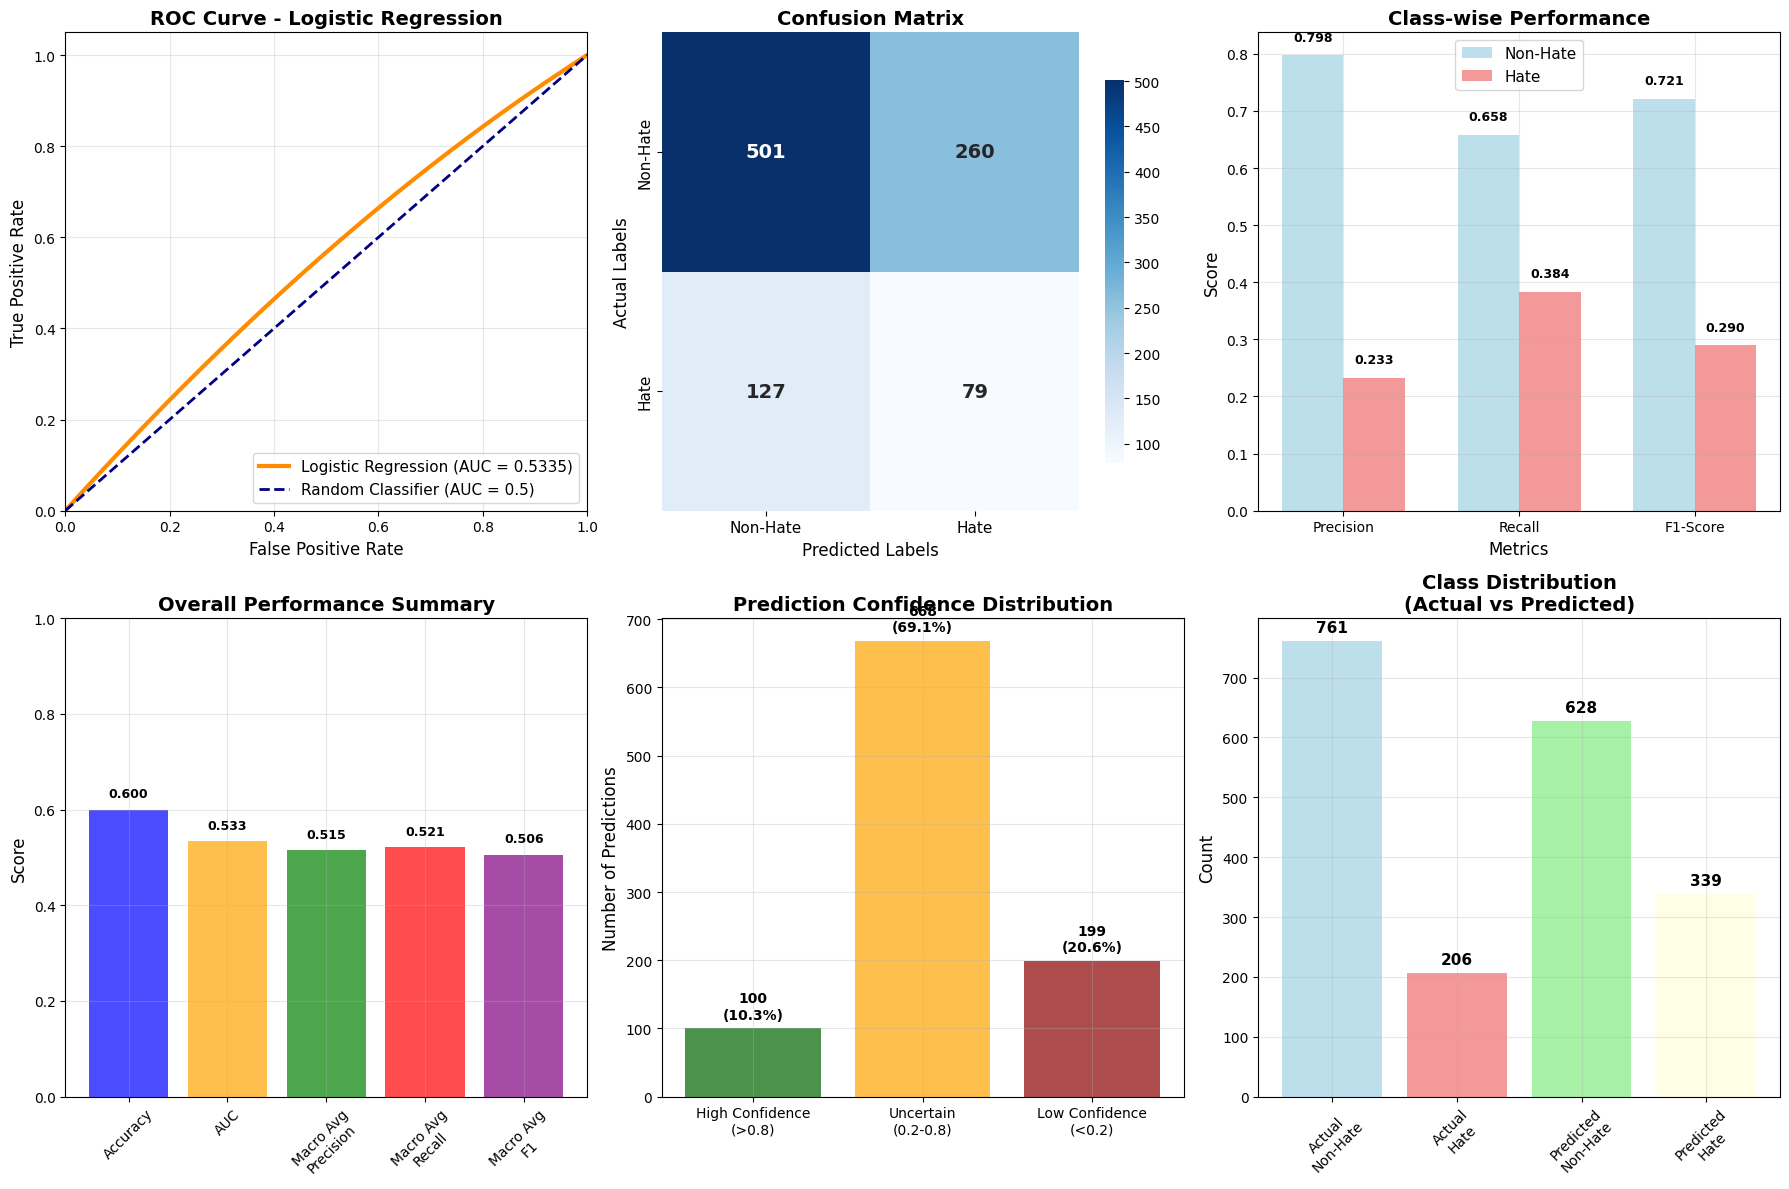

LOGISTIC REGRESSION MODEL PERFORMANCE ANALYSIS
Overall Performance:
* Accuracy: 0.5998 (60.0%)
* AUC: 0.5335

Confusion Matrix Breakdown:
* True Negatives (Correct Non-Hate): 501
* False Positives (Incorrect Hate): 260
* False Negatives (Missed Hate): 127
* True Positives (Correct Hate): 79

Class-wise Performance:
* Non-Hate Class:
  - Precision: 0.7978
  - Recall: 0.6583
  - F1: 0.7214
* Hate Class:
  - Precision: 0.2330
  - Recall: 0.3835
  - F1: 0.2899

Model Assessment:
* Macro Avg Precision: 0.5154
* Macro Avg Recall: 0.5209
* Macro Avg F1: 0.5057
* Hate Detection Rate: 38.4% (79/206 hate samples detected)
* Non-Hate Detection Rate: 65.8% (501/761 non-hate samples detected)

Prediction Confidence:
* High Confidence: 100 samples (10.3%)
* Uncertain: 668 samples (69.1%)
* Low Confidence: 199 samples (20.6%)
* Average Confidence: 0.4277
* AUC Assessment: Moderate discriminative ability

Visualization saved: logistic_regression_analysis.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Your Logistic Regression test results
test_accuracy = 0.5998
test_auc = 0.5335
confusion_matrix = np.array([[501, 260], [127, 79]])

# Performance metrics from your results
non_hate_precision = 0.7978
non_hate_recall = 0.6583
non_hate_f1 = 0.7214
hate_precision = 0.2330
hate_recall = 0.3835
hate_f1 = 0.2899

# Confidence analysis
high_confidence = 100  # >0.8
low_confidence = 199   # <0.2
uncertain = 668        # 0.2-0.8
total_samples = 967
avg_confidence = 0.4277

# Calculate metrics from confusion matrix
tn, fp, fn, tp = confusion_matrix.ravel()

# Generate ROC curve data (approximated from AUC score)
def generate_roc_curve_from_auc(auc_score, n_points=100):
    """Generate representative ROC curve from AUC score"""
    if auc_score == 0.5:
        # Random classifier
        fpr = np.linspace(0, 1, n_points)
        tpr = np.linspace(0, 1, n_points)
    else:
        # Create a curve that achieves the given AUC
        fpr = np.linspace(0, 1, n_points)
        # Create a curve that's better than random but achieves target AUC
        if auc_score > 0.5:
            tpr = fpr + (auc_score - 0.5) * 2 * (1 - fpr) * fpr * 4
        else:
            tpr = fpr - (0.5 - auc_score) * 2 * (1 - fpr) * fpr * 4
        tpr = np.clip(tpr, 0, 1)

    return fpr, tpr

fpr, tpr = generate_roc_curve_from_auc(test_auc)

# Create comprehensive plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ROC Curve
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=3, label=f'Logistic Regression (AUC = {test_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc="lower right", fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Confusion Matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
            cbar_kws={'shrink': 0.8}, annot_kws={'size': 14, 'weight': 'bold'})
axes[0, 1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Labels', fontsize=12)
axes[0, 1].set_ylabel('Actual Labels', fontsize=12)
axes[0, 1].set_xticklabels(['Non-Hate', 'Hate'], fontsize=11)
axes[0, 1].set_yticklabels(['Non-Hate', 'Hate'], fontsize=11)

# 3. Class-wise Performance Comparison
class_metrics = ['Precision', 'Recall', 'F1-Score']
non_hate_values = [non_hate_precision, non_hate_recall, non_hate_f1]
hate_values = [hate_precision, hate_recall, hate_f1]

x = np.arange(len(class_metrics))
width = 0.35

bars1 = axes[0, 2].bar(x - width/2, non_hate_values, width, label='Non-Hate', color='lightblue', alpha=0.8)
bars2 = axes[0, 2].bar(x + width/2, hate_values, width, label='Hate', color='lightcoral', alpha=0.8)

axes[0, 2].set_xlabel('Metrics', fontsize=12)
axes[0, 2].set_ylabel('Score', fontsize=12)
axes[0, 2].set_title('Class-wise Performance', fontsize=14, fontweight='bold')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(class_metrics)
axes[0, 2].legend(fontsize=11)
axes[0, 2].grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars1, non_hate_values):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
for bar, value in zip(bars2, hate_values):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Overall Performance Summary
overall_metrics = ['Accuracy', 'AUC', 'Macro Avg\nPrecision', 'Macro Avg\nRecall', 'Macro Avg\nF1']
macro_precision = (non_hate_precision + hate_precision) / 2
macro_recall = (non_hate_recall + hate_recall) / 2
macro_f1 = (non_hate_f1 + hate_f1) / 2
overall_values = [test_accuracy, test_auc, macro_precision, macro_recall, macro_f1]

bars = axes[1, 0].bar(overall_metrics, overall_values, color=['blue', 'orange', 'green', 'red', 'purple'], alpha=0.7)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Overall Performance Summary', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 1)

# Add value labels
for bar, value in zip(bars, overall_values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 5. Prediction Confidence Distribution
confidence_labels = ['High Confidence\n(>0.8)', 'Uncertain\n(0.2-0.8)', 'Low Confidence\n(<0.2)']
confidence_values = [high_confidence, uncertain, low_confidence]
confidence_colors = ['darkgreen', 'orange', 'darkred']

bars = axes[1, 1].bar(confidence_labels, confidence_values, color=confidence_colors, alpha=0.7)
axes[1, 1].set_ylabel('Number of Predictions', fontsize=12)
axes[1, 1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(True, alpha=0.3)

# Add value labels and percentages
for bar, value in zip(bars, confidence_values):
    percentage = value / total_samples * 100
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                   f'{value}\n({percentage:.1f}%)', ha='center', va='bottom',
                   fontweight='bold', fontsize=10)

# 6. Class Distribution (Actual vs Predicted)
categories = ['Actual\nNon-Hate', 'Actual\nHate', 'Predicted\nNon-Hate', 'Predicted\nHate']
actual_non_hate = tn + fp  # 761
actual_hate = fn + tp      # 206
predicted_non_hate = tn + fn  # 628
predicted_hate = fp + tp       # 339

distribution_values = [actual_non_hate, actual_hate, predicted_non_hate, predicted_hate]
distribution_colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']

bars = axes[1, 2].bar(categories, distribution_values, color=distribution_colors, alpha=0.8)
axes[1, 2].set_ylabel('Count', fontsize=12)
axes[1, 2].set_title('Class Distribution\n(Actual vs Predicted)', fontsize=14, fontweight='bold')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars, distribution_values):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                   f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('logistic_regression_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comprehensive analysis
print("=" * 70)
print("LOGISTIC REGRESSION MODEL PERFORMANCE ANALYSIS")
print("=" * 70)

print(f"Overall Performance:")
print(f"* Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"* AUC: {test_auc:.4f}")

print(f"\nConfusion Matrix Breakdown:")
print(f"* True Negatives (Correct Non-Hate): {tn}")
print(f"* False Positives (Incorrect Hate): {fp}")
print(f"* False Negatives (Missed Hate): {fn}")
print(f"* True Positives (Correct Hate): {tp}")

print(f"\nClass-wise Performance:")
print(f"* Non-Hate Class:")
print(f"  - Precision: {non_hate_precision:.4f}")
print(f"  - Recall: {non_hate_recall:.4f}")
print(f"  - F1: {non_hate_f1:.4f}")
print(f"* Hate Class:")
print(f"  - Precision: {hate_precision:.4f}")
print(f"  - Recall: {hate_recall:.4f}")
print(f"  - F1: {hate_f1:.4f}")

print(f"\nModel Assessment:")
macro_precision = (non_hate_precision + hate_precision) / 2
macro_recall = (non_hate_recall + hate_recall) / 2
macro_f1 = (non_hate_f1 + hate_f1) / 2
print(f"* Macro Avg Precision: {macro_precision:.4f}")
print(f"* Macro Avg Recall: {macro_recall:.4f}")
print(f"* Macro Avg F1: {macro_f1:.4f}")
print(f"* Hate Detection Rate: {hate_recall:.1%} ({tp}/{tp+fn} hate samples detected)")
print(f"* Non-Hate Detection Rate: {non_hate_recall:.1%} ({tn}/{tn+fp} non-hate samples detected)")

print(f"\nPrediction Confidence:")
print(f"* High Confidence: {high_confidence} samples ({high_confidence/total_samples*100:.1f}%)")
print(f"* Uncertain: {uncertain} samples ({uncertain/total_samples*100:.1f}%)")
print(f"* Low Confidence: {low_confidence} samples ({low_confidence/total_samples*100:.1f}%)")
print(f"* Average Confidence: {avg_confidence:.4f}")

if test_auc > 0.6:
    print(f"* AUC Assessment: Good discriminative ability")
elif test_auc > 0.5:
    print(f"* AUC Assessment: Moderate discriminative ability")
else:
    print(f"* AUC Assessment: Poor discriminative ability")

print(f"\nVisualization saved: logistic_regression_analysis.png")
print("=" * 70)